<a href="https://colab.research.google.com/github/torbenbillow/CBS-AML-PROJECT/blob/main/notebooks/00_welcome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [1]:
# ADD COMMENTS FOR EACH IMPORT TO EXPLAIN WHY WE NEED IT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, max_error, mean_absolute_percentage_error)

from google.colab import drive
pd.options.mode.copy_on_write = True # WHAT DO THIS DO?

# LOAD DATA FROM GOOGLE DRIVE

In [2]:
print("Loading raw data from Google Drive location...")
file_id = "1Iyr7zX8u0gKWKUWCSgZUpcvbTuYBmw1V"       # File id from Google Drive
url = f"https://drive.google.com/uc?id={file_id}"   # URL to Google Sheet with the inputted file_id
listings_raw = pd.read_csv(url)                     # Store the data in the listings_raw variable

print("Raw data successfully loaded.")

print("Raw dataframe shape:",listings_raw.shape)    # Print the shape of the dataframe so we have a baseline

Loading raw data from Google Drive location...
Raw data successfully loaded.
Raw dataframe shape: (22684, 79)


# DATA WRANGLING

## DISPLAY ALL RAW DATA COLUMNS AND MANUALLY REMOVE UNWANTED (DOMAIN KNOWLEDGE)

In [698]:
# Copy the original dataframe to the df variable, so the original data set can be used for comparisons.
df = listings_raw.copy()

# List all columns
list(df)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [699]:
# The following columns are irrelevant, and thus, we have chosen to drop them.
df = df.drop(columns=["listing_url","scrape_id","source","host_id","host_url","calendar_last_scraped","first_review","host_neighbourhood"])

# The following columns could impact a listing's "success" (discrimination, etc.), but due to the complexity and the scope of this project,
# we have chosen to drop it.
df = df.drop(columns=["name","picture_url","host_name","host_thumbnail_url","host_picture_url"])

# Dropping the following columns in favor of "calculated_host_listings_count," because that is the direct calculation of how many listings
# a host has at the time of scrape. The metadata also notes that this calculation is "unknown," and thereby less trustworthy.
df = df.drop(columns=["host_listings_count","host_total_listings_count"])

# Dropping in favor of "host_identitity_verified," which is a boolean that indicates whether or not the host is verified.
df = df.drop(columns=["host_verifications"])

# Dropping in favor of "neighborhood_cleansed."
df = df.drop(columns=["neighbourhood"])

# Dropping the following, as they are completely empty attributes.
df = df.drop(columns=["neighbourhood_group_cleansed","calendar_updated","license"])

# Dropping the following columns in favor of "mini_nights" and "maximum_nights."
df = df.drop(columns=["minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm"])

# Dropping the following columns, because there is no information about they represent.
df = df.drop(columns=["has_availability","availability_eoy"])

''' Dropping the following columns, because we have selected "availability_30" as our target variable. We believe this the most accurate
indicator of a listing's popularity/success, because listings will on average be booked more in the short term than in the long term.
We would be able to attribute the availability to an actual "interest level," rather than a lack of booking simply due to time considerations.
Seasonality should not matter since the scope of our listings is limited to Copenhagen, so theoretically, all listings would be impacted equally
by seasonality. '''
df = df.drop(columns=["availability_60","availability_90","availability_365"])

# Dropping the following columns in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ltm","number_of_reviews_l30d"])

# Dropping in favor "number_of_reviews" for simplicity.
df = df.drop(columns=["number_of_reviews_ly"])

# Irrelevant and would introduce data leakage.
df = df.drop(columns=["estimated_revenue_l365d"])

# Dropping the following attributes because they will not be available at the time of prediction.
df = df.drop(columns=["review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"])

# Dropping the following columns in favor of "calculated_host_listings_count" for simplicity.
df = df.drop(columns=["calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"])

# Dropping in favor of "number_of_reviews."
df = df.drop(columns=["reviews_per_month"])


In [700]:
# Print size of dataframe before drops
print("Dataframe shape before column drops:",listings_raw.shape)

# Print size of dataframe after drops
print("Dataframe shape after column drops:",df.shape)

print("\n")
print("Number of columns removed:",listings_raw.shape[1] - df.shape[1])
print("Number of rows removed:",listings_raw.shape[0] - df.shape[0])

Dataframe shape before column drops: (22684, 79)
Dataframe shape after column drops: (22684, 33)


Number of columns removed: 46
Number of rows removed: 0


## AUDIT THE DATA TO DETERMINE WHAT NEEDS TO BE CLEANSED

In [701]:
# Create a function that will audit the data and provide an overview, making it easier to systematically determine what needs to be cleansed.

def audit_dataframe(df, name="DataFrame"):
    print(f"\n=== AIRBNB DATA AUDIT: {name} ===\n")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # ----- SHOW NULL SUMMARY -----
    print("---- Missing Values ----")
    nulls = df.isnull().sum()
    nulls_percent = (df.isnull().mean() * 100).round(2)
    null_summary = pd.DataFrame({
        "null_count": nulls,
        "null_percent": nulls_percent,
        "dtype": df.dtypes
    })
    display(null_summary[nulls > 0].sort_values("null_percent", ascending=False))
    print("\n")

    # ----- SHOW DATA TYPES -----
    print("---- Data Types ----")
    data_types = df.dtypes.rename("dtype").to_frame()
    display(data_types)

    print("\n")

    # ----- SHOW DESCRIPTIVE STATS -----
    print("---- Descriptive Statistics (Numerical) ----")
    display(df.describe(include=[np.number]).transpose().round(2))
    print("\n")

    print("---- Descriptive Statistics (Categorical) ----")
    display(df.describe(include=['object', 'category']).transpose())
    print("\n")

    # ----- SHOW UNIQUE VALUES -----
    print("---- Unique Value Counts ----")
    unique_counts = (df.nunique().sort_values().rename("unique_counts").to_frame())
    display(unique_counts)
    print("\n")

    # ----- SHOW SAMPLE VALUES FOR EACH COLUMN -----
    print("---- Sample Values ----")
    display(df.sample(5))
    print("\n")

    # ----- SHOW BOOLEAN DISTRIBUTION -----
    print("---- Boolean Column Distributions ----")
    bool_cols = df.select_dtypes(include="bool").columns
    if len(bool_cols) > 0:
        for col in bool_cols:
            print(f"{col}:\n{df[col].value_counts()}")
            print("")

    else:
      print("\n")
      print("NO BOOLEAN COLUMNS FOUND")
    print("\n")

    # ----- SHOW CATEGORICAL CARDINALITY -----
    print("---- Categorical Cardinality ----")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    cardinality_df = pd.DataFrame({
        "column": cat_cols,
        "unique_values": [df[col].nunique() for col in cat_cols]
    })
    display(cardinality_df)
    print("\n")

    # ----- SHOW DUPLICATES -----
    print("---- Duplicate Rows ----")

    dupes = df.duplicated().sum()
    duplicate_df = pd.DataFrame({"duplicate_rows": [dupes]})
    display(duplicate_df)
    print("\n")

    print("=== END AUDIT ===\n")


In [702]:
# Run the function to show the various metrics defined

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 22684 rows × 33 columns

---- Missing Values ----


null_count  null_percent    dtype
neighborhood_overview        14459         63.74   object
host_about                   13381         58.99   object
bathrooms                     8858         39.05  float64
beds                          8856         39.04  float64
price                         8853         39.03   object
host_response_time            7853         34.62   object
host_response_rate            7853         34.62   object
host_acceptance_rate          5288         23.31   object
host_location                 4082         18.00   object
last_review                   3146         13.87   object
bedrooms                       716          3.16  float64
description                    614          2.71   object
host_since                     529          2.33   object
host_identity_verified         529          2.33   object
host_has_profile_pic           529          2.33   object
host_is_superhost              238          1.05   object
bathrooms_text                   8          0.04   object



---- Data Types ----


dtype
id                                int64
last_scraped                     object
description                      object
neighborhood_overview            object
host_since                       object
host_location                    object
host_about                       object
host_response_time               object
host_response_rate               object
host_acceptance_rate             object
host_is_superhost                object
host_has_profile_pic             object
host_identity_verified           object
neighbourhood_cleansed           object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bathrooms_text                   object
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
number_of_reviews                 int64
estimated_occupancy_l365d         int64
last_review                      object
instant_bookable                 object
calculated_host_listings_count    int64



---- Descriptive Statistics (Numerical) ----


count          mean           std       min  \
id                              22684.0  6.582521e+17  5.448303e+17  29118.00   
latitude                        22684.0  5.568000e+01  2.000000e-02     55.62   
longitude                       22684.0  1.256000e+01  3.000000e-02     12.45   
accommodates                    22684.0  3.330000e+00  1.640000e+00      1.00   
bathrooms                       13826.0  1.100000e+00  3.400000e-01      0.00   
bedrooms                        21968.0  1.620000e+00  8.900000e-01      0.00   
beds                            13828.0  1.870000e+00  1.270000e+00      0.00   
minimum_nights                  22684.0  4.640000e+00  1.778000e+01      1.00   
maximum_nights                  22684.0  3.055400e+02  3.767400e+02      1.00   
availability_30                 22684.0  6.140000e+00  8.670000e+00      0.00   
number_of_reviews               22684.0  1.893000e+01  4.594000e+01      0.00   
estimated_occupancy_l365d       22684.0  3.166000e+01  4.988000e+01      0.00   
calculated_host_listings_count  22684.0  4.870000e+00  2.687000e+01      1.00   

                                        25%           50%           75%  \
id                              36348049.75  7.954608e+17  1.157326e+18   
latitude                              55.67  5.568000e+01  5.570000e+01   
longitude                             12.54  1.256000e+01  1.258000e+01   
accommodates                           2.00  3.000000e+00  4.000000e+00   
bathrooms                              1.00  1.000000e+00  1.000000e+00   
bedrooms                               1.00  1.000000e+00  2.000000e+00   
beds                                   1.00  1.000000e+00  2.000000e+00   
minimum_nights                         2.00  3.000000e+00  4.000000e+00   
maximum_nights                        20.00  9.000000e+01  3.650000e+02   
availability_30                        0.00  1.000000e+00  9.000000e+00   
number_of_reviews                      2.00  7.000000e+00  1.900000e+01   
estimated_occupancy_l365d              0.00  1.200000e+01  4.000000e+01   
calculated_host_listings_count         1.00  1.000000e+00  1.000000e+00   

                                         max  
id                              1.451628e+18  
latitude                        5.573000e+01  
longitude                       1.264000e+01  
accommodates                    1.600000e+01  
bathrooms                       8.000000e+00  
bedrooms                        9.000000e+00  
beds                            1.600000e+01  
minimum_nights                  1.111000e+03  
maximum_nights                  1.125000e+03  
availability_30                 3.000000e+01  
number_of_reviews               2.366000e+03  
estimated_occupancy_l365d       2.550000e+02  
calculated_host_listings_count  2.470000e+02



---- Descriptive Statistics (Categorical) ----


count unique  \
last_scraped            22684      6   
description             22070  21430   
neighborhood_overview    8225   7901   
host_since              22155   4729   
host_location           18602    333   
host_about               9303   7736   
host_response_time      14831      4   
host_response_rate      14831     91   
host_acceptance_rate    17396    101   
host_is_superhost       22446      2   
host_has_profile_pic    22155      2   
host_identity_verified  22155      2   
neighbourhood_cleansed  22684     11   
property_type           22684     55   
room_type               22684      4   
bathrooms_text          22676     21   
amenities               22684  21560   
price                   13831   2496   
last_review             19538   1742   
instant_bookable        22684      2   

                                                                      top  \
last_scraped                                                   2025-07-01   
description             Your family will be close to everything when y...   
neighborhood_overview   This area is known for its mix of restaurants ...   
host_since                                                     2018-05-03   
host_location                                         Copenhagen, Denmark   
host_about              Vi udlejer møblerede lejligheder og har mere e...   
host_response_time                                         within an hour   
host_response_rate                                                   100%   
host_acceptance_rate                                                 100%   
host_is_superhost                                                       f   
host_has_profile_pic                                                    t   
host_identity_verified                                                  t   
neighbourhood_cleansed                                            Nrrebro   
property_type                                          Entire rental unit   
room_type                                                 Entire home/apt   
bathrooms_text                                                     1 bath   
amenities               ["TV", "Paid parking on premises", "Washer", "...   
price                                                             $900.00   
last_review                                                    2025-06-22   
instant_bookable                                                        f   

                         freq  
last_scraped             6401  
description                52  
neighborhood_overview      11  
host_since                251  
host_location           15966  
host_about                247  
host_response_time       5742  
host_response_rate      10528  
host_acceptance_rate     4924  
host_is_superhost       19672  
host_has_profile_pic    21426  
host_identity_verified  19641  
neighbourhood_cleansed   4097  
property_type           13038  
room_type               20780  
bathrooms_text          18162  
amenities                  37  
price                     336  
last_review               817  
instant_bookable        20502



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_identity_verified                      2
host_has_profile_pic                        2
instant_bookable                            2
room_type                                   4
host_response_time                          4
last_scraped                                6
bedrooms                                   10
bathrooms                                  11
neighbourhood_cleansed                     11
accommodates                               16
beds                                       16
bathrooms_text                             21
calculated_host_listings_count             24
availability_30                            31
property_type                              55
minimum_nights                             71
host_response_rate                         91
estimated_occupancy_l365d                  94
host_acceptance_rate                      101
maximum_nights                            175
host_location                             333
number_of_reviews                         336
last_review                              1742
price                                    2496
host_since                               4729
host_about                               7736
neighborhood_overview                    7901
latitude                                15397
longitude                               17045
description                             21430
amenities                               21560
id                                      22684



---- Sample Values ----


id last_scraped  \
17868  1186628029632397761   2025-07-01   
21394  1410289457524695920   2025-07-01   
19590  1291782061959542771   2025-07-01   
6908              44937459   2025-06-30   
15666  1081934381662588076   2025-07-02   

                                             description  \
17868  Experience charming Sydhavn! My  cozy apartmen...   
21394  This bright and peaceful 2-bedroom apartment i...   
19590  Small two-room studio for families, couples or...   
6908   Lovely and charming Copenhagen apartment in th...   
15666  Make some memories in this unique and family-f...   

      neighborhood_overview  host_since        host_location  \
17868                   NaN  2015-06-17  Copenhagen, Denmark   
21394                   NaN  2015-12-09  Copenhagen, Denmark   
19590                   NaN  2024-03-09                  NaN   
6908                    NaN  2020-08-17                  NaN   
15666                   NaN  2020-02-12                  NaN   

                                              host_about  host_response_time  \
17868  I’m a travel enthusiast who appreciate explori...  within a few hours   
21394                                                NaN      within an hour   
19590                                                NaN                 NaN   
6908                                                 NaN                 NaN   
15666                                                NaN  within a few hours   

      host_response_rate host_acceptance_rate  ...  \
17868               100%                  77%  ...   
21394               100%                  71%  ...   
19590                NaN                   0%  ...   
6908                 NaN                  NaN  ...   
15666               100%                  60%  ...   

                                               amenities      price  \
17868  ["Long term stays allowed", "EV charger", "TV"...        NaN   
21394  ["Dining table", "Trash compactor", "Dishes an...    $798.00   
19590  ["Washer", "Kitchen", "Wifi", "Paid parking on...        NaN   
6908   ["Private entrance", "Essentials", "Hangers", ...        NaN   
15666  ["Paid parking off premises", "Wifi", "Stove",...  $1,475.00   

      minimum_nights maximum_nights  availability_30  number_of_reviews  \
17868              3             30                0                  9   
21394              3             31                0                  3   
19590              7            365                0                  0   
6908               2           1125                0                  0   
15666              4            365               15                  1   

      estimated_occupancy_l365d last_review  instant_bookable  \
17868                        54  2025-06-08                 f   
21394                        18  2025-06-16                 t   
19590                         0         NaN                 f   
6908                          0         NaN                 f   
15666                         8  2025-05-04                 f   

       calculated_host_listings_count  
17868                               1  
21394                               1  
19590                               1  
6908                                1  
15666                               1  

[5 rows x 33 columns]



---- Boolean Column Distributions ----


NO BOOLEAN COLUMNS FOUND


---- Categorical Cardinality ----


column  unique_values
0             last_scraped              6
1              description          21430
2    neighborhood_overview           7901
3               host_since           4729
4            host_location            333
5               host_about           7736
6       host_response_time              4
7       host_response_rate             91
8     host_acceptance_rate            101
9        host_is_superhost              2
10    host_has_profile_pic              2
11  host_identity_verified              2
12  neighbourhood_cleansed             11
13           property_type             55
14               room_type              4
15          bathrooms_text             21
16               amenities          21560
17                   price           2496
18             last_review           1742
19        instant_bookable              2



---- Duplicate Rows ----


duplicate_rows
0               0



=== END AUDIT ===



## FILTER THE DATASET TO REMOVE LISTINGS WITHOUT REVIEWS AND WITH NO OCCUPANCY IN THE LAST YEAR

In [703]:
'''
We have chosen to remove listings without reviews in 2025 and no occupancy in the last year. We will now filter "last_review" for
listings that have a review within 6 months of the scrape date and "estimated_occupancy_l365d" for listings that have a non-zero value. We have
done this to ensure we are including only listings that are active, and thereby more informative for our model.

We recognize that this approach may introduce selection bias, since the remaining dataset over-represents highly active, consistently booked listings.
As a result, our model will be trained only on relatively "successful" or "popular" listings and may systematically overestimate occupancy for
lower-activity or newly listed properties. In other words, the predictions may not generalize as well to the full population of Airbnb listings,
because the model never sees ultra low-engagement listings.

'''
df = df.query(
    "last_review >= '2025-01-01' and estimated_occupancy_l365d > 0"
)

In [704]:
# Check sizes of data and filtered data
print("Row count before filtering:", len(listings_raw))
print("Row count after filtering:", len(df))

Row count before filtering: 22684
Row count after filtering: 10132


In [705]:
# We are now dropping the aforementioned columns, as they are no longer needed post-filtering.
df = df.drop(columns=["last_review","estimated_occupancy_l365d"])

## CLEAN UP BOOLEAN COLUMNS

In [706]:
# As seen in the data audit, none of the columns are of "bool" type. Some columns have boolean values "f" and "t", so we change to 0 or 1.
bool_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable"
]

bool_map = {
    "t": 1,
    "f": 0,
    "true": 1,
    "false": 0,
    True: 1,
    False: 0,
}

# Fix boolean values in the datasets
for col in bool_cols:
   df[col] = (df[col].map(bool_map).astype("Int64"))

# Fill missing superhost values with 0 in the dataset. We are assuming that hosts without a value here are NOT superhosts.
df["host_is_superhost"] = df["host_is_superhost"].fillna(0).astype("Int64")

# Print results
results = pd.DataFrame({
    "column": bool_cols,
    "unique_values": [df[col].unique().tolist() for col in bool_cols]
})
display(results)

column unique_values
0       host_is_superhost        [1, 0]
1    host_has_profile_pic  [1, <NA>, 0]
2  host_identity_verified  [1, 0, <NA>]
3        instant_bookable        [0, 1]

## CLEAN UP MISSING "bed" AND "bedroom" ATTRIBUTES

There are three measures for how many people a property fits:
1.   "accommodates" = max number of guests
2.   "bedrooms" = number of bedrooms
3.   "beds" = number of beds

In [707]:
display(df[['accommodates','bedrooms','beds']].isna().sum().rename("null_counts"))

accommodates       0
bedrooms         158
beds            2261
Name: null_counts, dtype: int64

The "accommodates" attribute has no missingness, while the others do, so we use combinations of them to impute values.

In [708]:
# Only use rows where all three variables are valid (non-missing, non-zero)
valid = df[
    (df['accommodates'] > 0) &
    (df['beds'] > 0) &
    (df['bedrooms'] > 0)
]

# Compute ratios
valid['guests_per_bed'] = valid['accommodates'] / valid['beds']
valid['beds_per_bedroom'] = valid['beds'] / valid['bedrooms']
valid['guests_per_bedroom'] = valid['accommodates'] / valid['bedrooms']

# Get averages and medians
summary = valid[['guests_per_bed', 'beds_per_bedroom', 'guests_per_bedroom']].agg(['mean', 'median'])
print("Statistics before imputation:\n")
display(summary)
print("\n")

# Use medians for integers
guests_per_bed = summary.loc['median', 'guests_per_bed']
beds_per_bedroom = summary.loc['median', 'beds_per_bedroom']
guests_per_bedroom = summary.loc['median', 'guests_per_bedroom']

# Impute median values where missing
# For missing beds but nonmissing bedrooms, impute median beds per bedroom
df.loc[df['beds'].isna() & df['bedrooms'].notna(), 'beds'] = df['bedrooms'] * beds_per_bedroom

# For remaining missing beds, divide max guest count by median guests per bed
df.loc[df['beds'].isna(), 'beds'] = df['accommodates'] / guests_per_bed

# For missing bedrooms but nonmissing bedrooms, divide beds by beds per bedroom
df.loc[df['bedrooms'].isna() & df['beds'].notna(), 'bedrooms'] = df['beds'] / beds_per_bedroom

# For remaining missing bedrooms, divide max guest count by median guests per bedroom
df.loc[df['bedrooms'].isna(), 'bedrooms'] = df['accommodates'] / guests_per_bedroom

# Re-check missingness
recheck = pd.DataFrame({
    "missing_values": df[['accommodates','bedrooms','beds']].isna().sum()
    })
print("Check missingness after imputation:\n")
display(recheck)

Statistics before imputation:



guests_per_bed  beds_per_bedroom  guests_per_bedroom
mean          1.985025           1.22465            2.261135
median        2.000000           1.00000            2.000000



Check missingness after imputation:



missing_values
accommodates               0
bedrooms                   0
beds                       0

## CLEAN UP MISSING "bathroom" AND "bathroom_text" ATTRIBUTES

Some properties are missing a number of bathrooms in the "bathrooms" attribute. Instead, it's stored as a string in the "bathrooms_text" attribute.


In [709]:
print("Check null counts:\n")
display(df[["bathrooms", "bathrooms_text"]].isna().sum().to_frame(name="null_count"))
print("\n")
print("Show top 10 examples where \"bathrooms\" is null:\n")
display(df.loc[df["bathrooms"].isna(),["bathrooms","bathrooms_text"]].head(10))
print("\n")
print("Show examples where \"bathrooms_text\" contains \"half-bath\" and \"bathrooms\" is null:\n")
mask = (
    df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
    & df["bathrooms"].isna()
)
display(df.loc[mask, ["bathrooms","bathrooms_text"]])

Check null counts:



null_count
bathrooms             2262
bathrooms_text           2



Show top 10 examples where "bathrooms" is null:



bathrooms bathrooms_text
7          NaN      1.5 baths
8          NaN  1 shared bath
9          NaN      1.5 baths
38         NaN         1 bath
44         NaN         1 bath
54         NaN         1 bath
61         NaN         1 bath
83         NaN         1 bath
98         NaN         1 bath
106        NaN            NaN



Show examples where "bathrooms_text" contains "half-bath" and "bathrooms" is null:



bathrooms    bathrooms_text
2659         NaN         Half-bath
2844         NaN         Half-bath
3617         NaN         Half-bath
3692         NaN         Half-bath
4605         NaN         Half-bath
5559         NaN         Half-bath
6068         NaN         Half-bath
10080        NaN         Half-bath
11789        NaN         Half-bath
12143        NaN         Half-bath
12360        NaN  Shared half-bath
12425        NaN         Half-bath
12821        NaN         Half-bath
13471        NaN         Half-bath
14031        NaN         Half-bath
15134        NaN         Half-bath
15428        NaN         Half-bath
19732        NaN         Half-bath
20713        NaN         Half-bath
20976        NaN  Shared half-bath

In [710]:
# Convert bathrooms_text to string and normalize spacing/casing
bt = df["bathrooms_text"].astype(str).str.lower().str.strip()

# Special case: map any form of "half-bath" to 0.5
half_bath_mask = bt.str.contains("half-bath", na=False)
df.loc[half_bath_mask, "bathrooms"] = 0.5

# Extract numeric values (e.g., "1 bath", "2.5 baths")
bathrooms_from_text = (
    bt.str.extract(r'(\d+(\.\d+)?)')[0]  # capture integers or decimals
    .astype(float)
)

# Fill remaining missing bathroom values using numeric extraction
df["bathrooms"] = df["bathrooms"].fillna(bathrooms_from_text)

In [711]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())

"bathrooms" null count: 2


In [712]:
print("Show top 10 examples:\n")
display(df[["bathrooms","bathrooms_text"]].head(10))
print("\n")
print("Show examples where \"bathrooms_text\" contained \"half-bath\":\n")
mask = df["bathrooms_text"].astype(str).str.contains("half", case=False, na=False)
display(df.loc[mask, ["bathrooms","bathrooms_text"]])

Show top 10 examples:



bathrooms bathrooms_text
2         2.0        2 baths
4         1.0         1 bath
5         2.0        2 baths
7         1.5      1.5 baths
8         1.0  1 shared bath
9         1.5      1.5 baths
10        1.0         1 bath
14        1.0         1 bath
16        1.0         1 bath
17        1.0         1 bath



Show examples where "bathrooms_text" contained "half-bath":



bathrooms     bathrooms_text
259          0.5  Private half-bath
960          0.5          Half-bath
2433         0.5          Half-bath
2659         0.5          Half-bath
2844         0.5          Half-bath
...          ...                ...
21673        0.5          Half-bath
21815        0.5   Shared half-bath
22042        0.5   Shared half-bath
22358        0.5   Shared half-bath
22437        0.5  Private half-bath

[92 rows x 2 columns]

In [713]:
# Drop rest of missing values since the row count is so low

df = df.dropna(subset=['bathrooms'])

In [714]:
print("\"bathrooms\" null count:", df["bathrooms"].isna().sum())

"bathrooms" null count: 0


In [715]:
# Drop bathrooms_text
df = df.drop(columns=["bathrooms_text"])

## TRANSFORM "description" ATTRIBUTE BY ADDING "description_missing" AND "description_length" ATTRIBUTES

In [716]:
# Description has some missing values
print("\"description\" null count:", df["description"].isna().sum())

"description" null count: 181


In [717]:
df['description_missing'] = df['description'].isna().astype(int) # Make flag for missing description
df['description_length'] = df['description'].fillna('').str.len() # Add description length

# Show the results of adding the above columns
print("Missing descriptions examples:\n")
display(df[df['description_missing'] == 1][['description', 'description_missing', 'description_length']].head())
print("\n")
print("Completed descriptions examples:\n")
display(df[df['description_missing'] == 0][['description', 'description_missing', 'description_length']].head())

Missing descriptions examples:



description  description_missing  description_length
21         NaN                    1                   0
22         NaN                    1                   0
33         NaN                    1                   0
38         NaN                    1                   0
62         NaN                    1                   0



Completed descriptions examples:



description  description_missing  \
2  You enter a narrow entrance and feel the good ...                    0   
4  It doesn't get more central than this. Histori...                    0   
5  Big, bright, airy and attractive apartment dec...                    0   
7  Welcome to our home with a view of the Lakes. ...                    0   
8  Adorable apartment in peaceful, green and old-...                    0   

   description_length  
2                 482  
4                 412  
5                  75  
7                 558  
8                 515

In [718]:
# We are now dropping the "description" attribute, as we no longer need it (we are not doing any text analysis).
df = df.drop(columns=["description"])

## TRANSFORM "host_since" ATTRIBUTE BY ADDING "host_tenure_days" ATTRIBUTE

In [719]:
# Data has a host_since feature, so we use it to create a "host_tenure_days" column
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
latest_scrape = pd.to_datetime(df['last_scraped']).max() # Isolate the latest scrape date for calculation
df['host_tenure_days'] = (latest_scrape - df['host_since']).dt.days # Create new "host_tenure_days" attribute

In [720]:
print("\"host_tenure_days\" null count:", df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 257


In [721]:
# Drop the remaining nulls for host_tenure_days, as it is a relatively small number.
df = df.dropna(subset=['host_tenure_days'])

In [722]:
print("\"host_tenure_days\" null count:",df["host_tenure_days"].isna().sum())

"host_tenure_days" null count: 0


In [723]:
# Drop "host_since" and "last_scraped" columns, as we no longer need them
df = df.drop(columns=["host_since", "last_scraped"])

In [724]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 30)


## TRANSFORM "host_about" ATTRIBUTE BY ADDING "host_about_missing" AND "host_about_length" ATTRIBUTES

In [725]:
# Data has a host_about feature, so we use it to create "host_about_missing" and "host_about_length" columns
df['host_about_missing'] = df['host_about'].isna().astype(int) # Make flag for host about
df['host_about_length'] = df['host_about'].fillna('').str.len() # Host about length

In [726]:
print("\"host_about_missing\" null count:",df["host_about_missing"].isna().sum())
print("\"host_about_length\" null count:",df["host_about_length"].isna().sum())

"host_about_missing" null count: 0
"host_about_length" null count: 0


In [727]:
# We are now dropping the "host_about" attribute, as we are not doing any text analysis
df = df.drop(columns=["host_about"])

In [728]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 31)


## TRANSFORM "host_response_rate" AND "host_acceptance_rate" BY ADDING "...missing" ATTRIBUTES

In [729]:
# Format as float, add missing flag, fill previously missing value with median
for col in ["host_response_rate", "host_acceptance_rate"]:
  temp = df[col].astype(str).str.strip().str.rstrip('%').replace('', np.nan)
  df[col] = pd.to_numeric(temp, errors='coerce')
  df[f"{col}_missing"] = df[col].isna().astype(int)
  df[col] = df[col].fillna(df[col].median())

In [730]:
cols = [
    "host_response_rate",
    "host_response_rate_missing",
    "host_acceptance_rate",
    "host_acceptance_rate_missing"
]

print("=== Missing response or acceptance rate ===")
display(df[df["host_response_rate_missing"] == 1].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 1].sample(5)[cols])

print("\n=== Not missing ===")
display(df[df["host_response_rate_missing"] == 0].sample(5)[cols])
display(df[df["host_acceptance_rate_missing"] == 0].sample(5)[cols])

=== Missing response or acceptance rate ===


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
6717                100.0                           1                  55.0   
15096               100.0                           1                  50.0   
1626                100.0                           1                  81.0   
16043               100.0                           1                 100.0   
15626               100.0                           1                 100.0   

       host_acceptance_rate_missing  
6717                              0  
15096                             0  
1626                              1  
16043                             0  
15626                             0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
4776                100.0                           1                  81.0   
7546                100.0                           1                  81.0   
1801                100.0                           1                  81.0   
7448                100.0                           1                  81.0   
10662               100.0                           1                  81.0   

       host_acceptance_rate_missing  
4776                              1  
7546                              1  
1801                              1  
7448                              1  
10662                             1


=== Not missing ===


host_response_rate  host_response_rate_missing  host_acceptance_rate  \
4899                100.0                           0                  89.0   
16706                90.0                           0                  63.0   
16386               100.0                           0                 100.0   
7045                100.0                           0                  97.0   
20053               100.0                           0                 100.0   

       host_acceptance_rate_missing  
4899                              0  
16706                             0  
16386                             0  
7045                              0  
20053                             0

host_response_rate  host_response_rate_missing  host_acceptance_rate  \
6396                100.0                           0                  99.0   
7048                100.0                           0                 100.0   
9739                100.0                           0                  67.0   
15318               100.0                           1                  73.0   
19772               100.0                           1                  10.0   

       host_acceptance_rate_missing  
6396                              0  
7048                              0  
9739                              0  
15318                             0  
19772                             0

## TRANSFORM "host_response_time" ATTRIBUTE BY ADDING CATEGORY FOR MISSING VALUES CALLED "unknown"

In [731]:
# Response time is a categorical feature
# Fill unknown or missing response time with category "unknown"
df['host_response_time'] = df['host_response_time'].fillna('unknown')

In [732]:
cols = [
    "accommodates",
    "bedrooms",
    "bathrooms",
    "host_response_time"
]
print("Display sample of rows where \"host_response_time\" is null:")
display(df[df["host_response_time"] == "unknown"].sample(5)[cols])
print("\n")

print("Display sample of rows where \"host_response_time\" is not null:")
display(df[df["host_response_time"] != "unknown"].sample(5)[cols])

Display sample of rows where "host_response_time" is null:


accommodates  bedrooms  bathrooms host_response_time
14647             3       1.0        1.0            unknown
12593             2       1.0        1.0            unknown
10535             2       1.0        1.0            unknown
19782             3       1.0        1.0            unknown
15085             2       1.0        1.0            unknown



Display sample of rows where "host_response_time" is not null:


accommodates  bedrooms  bathrooms  host_response_time
7270              5       3.0        1.0        within a day
4736              3       1.0        1.0      within an hour
15346             4       2.0        1.0        within a day
62                2       1.0        1.0  a few days or more
10749             2       1.0        1.0        within a day

## TRANSFORM "neighborhood_overview" ATTRIBUTE BY ADDING "neighborhood_overview_length" AND "neighborhood_overview_missing" ATTRIBUTES

In [733]:
# neighborhood_overview is a description of the neighborhood written by the host

df['neighborhood_overview_missing'] = df['neighborhood_overview'].isna().astype(int) # Make flag for neighboorhood overview
df['neighborhood_overview_length'] = df['neighborhood_overview'].fillna('').str.len() # Neighborhood overview length

# Print results
print("\"neighborhood_overview_missing\" null count:",df["neighborhood_overview_missing"].isna().sum())
print("\"neighborhood_overview_length\" null count:",df["neighborhood_overview_length"].isna().sum())

"neighborhood_overview_missing" null count: 0
"neighborhood_overview_length" null count: 0


In [734]:
# We are now dropping the "neighborhood_overview" attribute, as we are not doing any text analysis
df = df.drop(columns=["neighborhood_overview"])

In [735]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 34)


## TRANSFORM "host_location" ATTRIBUTE BY ADDING "host_location_missing" ATTRIBUTE

In [736]:
df['host_location_missing'] = df['host_location'].isna().astype(int) # Make flag for host location

# Print results
print("\"host_location_missing\" null count:",df["host_location_missing"].isna().sum())

"host_location_missing" null count: 0


In [737]:
# We are now dropping the "host_location" attribute, as we are not doing any text analysis
df = df.drop(columns=["host_location"])

In [738]:
# Check df shape
print("Data set shape:",df.shape)

Data set shape: (9873, 34)


## CLEAN UP "host_has_profile_pic" AND "host_identity_verified" ATTRIBUTES

In [739]:
# We can see based on the information below, that a number of listings have a missing verification status and profile picture.
display(df[["host_has_profile_pic","host_identity_verified"]].isna().sum().rename("null_count"))

host_has_profile_pic      0
host_identity_verified    0
Name: null_count, dtype: int64

## MAKE DUMMIES FOR MOST IMPORTANT AMENITIES

In [740]:
import ast

# Parse once
df["amenities_list"] = df["amenities"].apply(ast.literal_eval)

# Define fuzzy keywords
# Amenities chosen from this official Airbnb article: https://sv.airbnb.com/resources/hosting-homes/a/the-amenities-guests-want-25
amenity_keywords = {
    "pool": ["pool"],
    "wifi": ["wifi", "wi-fi", "wi fi", "wireless internet"],
    "parking": ["free parking"],
    "ac": ["air conditioning", "portable heater"],
    "kitchen": ["kitchen"],
    "hot_tub": ["hot tub"],
    "washer": ["washer", "washing machine", "dryer"],
    "self_check_in": ["self check-in"],
    "tv": ["tv", "cable"],
    "grill": ["bbq grill"]
}

blocked_keywords = {
    "dryer": ["hair dryer"],
    "pool": ["pool table"],
    "washer": ["dishwasher"]
}

def has_keywords(amenities, keywords, blocked_keywords=None):
    if blocked_keywords is None:
        blocked_keywords = []

    amenities_lower = " | ".join(str(a).lower() for a in amenities)

    # First: check if a good keyword exists
    good_match = any(k in amenities_lower for k in keywords)

    # If no good keyword, return 0 immediately
    if not good_match:
        return 0

    # If a good keyword exists, we IGNORE blocked keywords
    return 1


for name, keywords in amenity_keywords.items():
    df[f"amenity_{name}"] = df["amenities_list"].apply(
        lambda lst: has_keywords(lst, keywords)
    )


In [741]:
print("Amenity missingness:")
for col in list(amenity_keywords)[0:9]:
    print(col, "missing:", df["amenity_"+col].isna().sum())

print("\nAmenity counts:")
for col in list(amenity_keywords)[0:9]:
    dummy_col = "amenity_" + col
    count_true = (df[dummy_col] == 1).sum()
    print(col, "true:", count_true)


Amenity missingness:
pool missing: 0
wifi missing: 0
parking missing: 0
ac missing: 0
kitchen missing: 0
hot_tub missing: 0
washer missing: 0
self_check_in missing: 0
tv missing: 0

Amenity counts:
pool true: 64
wifi true: 9652
parking true: 1162
ac true: 262
kitchen true: 9573
hot_tub true: 47
washer true: 8936
self_check_in true: 3999
tv true: 7511


In [742]:
# Drop unneeded columns
df = df.drop(columns=["amenities", "amenities_list"])

## CREATE HEX BINS FROM LONG/LAT TO ADD A MORE GRANULAR LOCATION ATTRIBUTE

In [743]:
# Neighborhood data is not very granular
# Long and lat used to create hexbins

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

# --- 1. Create GeoDataFrame from lat / lon ---

gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# Project to a metric CRS
gdf = gdf.to_crs(epsg=32632)


# --- 2. Helper: build a single regular hexagon around a center ---

def make_hexagon(cx, cy, radius):
    """
    Create a pointy-top regular hexagon centered at (cx, cy)
    with given radius (distance from center to each vertex).
    """
    # Pointy-top: start at 30° and step by 60°
    angles = np.deg2rad(np.arange(0, 360, 60) + 30)
    coords = [(cx + radius * np.cos(a), cy + radius * np.sin(a)) for a in angles]
    return Polygon(coords)


# --- 3. Build a hex grid over the extent of gdf ---

def make_hex_grid(gdf, radius):
    """
    Create a pointy-top hexagon grid covering the extent of gdf.
    radius = distance from hex center to each vertex (in CRS units, e.g. meters).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds

    # Pointy-top spacing:
    # horizontal distance between centers = sqrt(3) * radius
    # vertical distance between rows = 1.5 * radius
    dx = np.sqrt(3) * radius
    dy = 1.5 * radius

    cols = np.arange(xmin - dx, xmax + dx, dx)
    rows = np.arange(ymin - dy, ymax + dy, dy)

    hexes = []
    for row_idx, cy in enumerate(rows):
        for col_idx, cx in enumerate(cols):
            # Offset every second row by half the horizontal spacing
            cx_shifted = cx + (dx / 2.0 if row_idx % 2 == 1 else 0.0)
            hex_poly = make_hexagon(cx_shifted, cy, radius)
            hexes.append(hex_poly)

    hex_grid = gpd.GeoDataFrame(
        {"hex_id": range(len(hexes))},
        geometry=hexes,
        crs=gdf.crs
    )
    return hex_grid


# --- 4. Generate hex grid + optional trimming ---

hex_radius = 500  # meters
hex_grid = make_hex_grid(gdf, hex_radius)

# Optional trimming to a buffered convex hull of listings
study_area = gdf.geometry.union_all().convex_hull.buffer(2 * hex_radius)
hex_grid = hex_grid[hex_grid.intersects(study_area)].reset_index(drop=True)
hex_grid["hex_id"] = hex_grid.index  # reindex after trimming

# --- 5. Spatial join: assign each listing to a hex ---

joined = gpd.sjoin(
    gdf,
    hex_grid[["hex_id", "geometry"]],
    how="left",
    predicate="within"   # use "intersects" if you see edge-cases
)

# Join hex_id to the original df

df = df.merge(joined[["id", "hex_id"]], on="id")


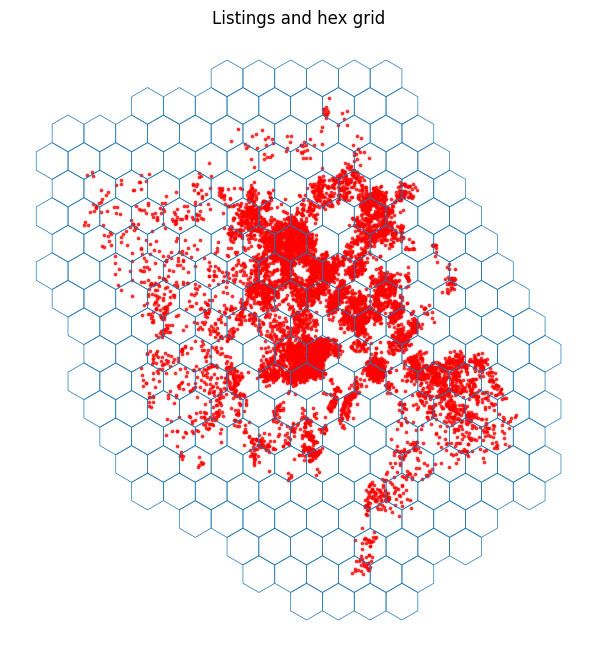

In [744]:
# --- Visualization: check that hexes look like hexes ---

fig, ax = plt.subplots(figsize=(8, 8))

# plot hex outlines
hex_grid.boundary.plot(ax=ax, linewidth=0.5)

# plot listing points
gdf.plot(ax=ax, markersize=3, color="red", alpha=0.7)

ax.set_title("Listings and hex grid")
ax.set_axis_off()
plt.show()

### Mapping hexes

In [745]:
# Sanity check hexbins by projecting on map of Copenhagen

import folium

# Convert hexes and points to WGS84 (lat/lon)
hex_wgs = hex_grid.to_crs(epsg=4326)
pts_wgs = gdf.to_crs(epsg=4326)

center_lat = pts_wgs.geometry.y.mean()
center_lon = pts_wgs.geometry.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

folium.GeoJson(
    hex_wgs,
    name="Hex grid",
    style_function=lambda feature: {
        "fillColor": "none",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.1,
    },
).add_to(m)

sample_pts = pts_wgs.sample(min(2000, len(pts_wgs)), random_state=0)

#for _, row in sample_pts.iterrows():
for _, row in pts_wgs.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m

In [746]:
# Count unique hexes assigned to the dataset
print("Unique hex_id:",df["hex_id"].nunique())

# Check for missingness
print("Missing in hex_id:",df["hex_id"].isna().sum())

# Drop id, longitude and latitude since they are not needed anymore
df = df.drop(columns=["id", "longitude", "latitude"])

print("df shape:", df.shape)

Unique hex_id: 143
Missing in hex_id: 0
df shape: (9873, 41)


In [747]:
list(df)

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'instant_bookable',
 'calculated_host_listings_count',
 'description_missing',
 'description_length',
 'host_tenure_days',
 'host_about_missing',
 'host_about_length',
 'host_response_rate_missing',
 'host_acceptance_rate_missing',
 'neighborhood_overview_missing',
 'neighborhood_overview_length',
 'host_location_missing',
 'amenity_pool',
 'amenity_wifi',
 'amenity_parking',
 'amenity_ac',
 'amenity_kitchen',
 'amenity_hot_tub',
 'amenity_washer',
 'amenity_self_check_in',
 'amenity_tv',
 'amenity_grill',
 'hex_id']

## CLEAN UP "price" ATTRIBUTE



In [748]:
# Remove $, commas, and spaces, then convert to numeric
price_clean = (
    df["price"]
    .astype(str)                             # handle existing ints / NA
    .str.replace(r'[\$,]', '', regex=True)   # remove $ and commas
    .str.strip()
)

# Convert to numeric, coercing bad values (like '<NA>') to NaN
price_numeric = pd.to_numeric(price_clean, errors="coerce")

# Store back as nullable integer
df["price"] = price_numeric.astype("Int64")

### VALIDATE PRICE ATTRIBUTE

In [749]:
df["price"].describe()

count         7634.0
mean      1375.48022
std      1178.182905
min            202.0
25%            880.0
50%           1166.0
75%           1600.0
max          63418.0
Name: price, dtype: Float64

The above price statistics seem to be reasonable. For the high and low ends of the spectrum, we spot checked the listings on Airbnb.

## CORRECT DATA TYPES

In [750]:
# -----------------------
# Define column groups
# -----------------------

# Columns that should be treated as categories
cat_cols = [
    "host_response_time",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "hex_id"
]

# Columns that should be nullable integers (Int64)
int_cols = [
    "accommodates",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "availability_30",
    "number_of_reviews",
    "calculated_host_listings_count",
    "description_missing",
    "description_length",
    "host_about_missing",
    "host_about_length",
    "host_response_rate_missing",
    "host_acceptance_rate_missing",
    "neighborhood_overview_missing",
    "neighborhood_overview_length",
    "host_location_missing",
    "amenity_pool",
    "amenity_wifi",
    "amenity_parking",
    "amenity_ac",
    "amenity_kitchen",
    "amenity_hot_tub",
    "amenity_washer",
    "amenity_self_check_in",
    "amenity_tv",
    "amenity_grill",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]

# True floats (allowing decimals)
float_cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "bathrooms",
    "host_tenure_days",
    "price",
]



# -------------------------------------------------
# Make sure beds / bedrooms are ints
# -------------------------------------------------
# Only do this if you're happy rounding any residual decimals
df["beds"] = df["beds"].round().astype("Int64")
df["bedrooms"] = df["bedrooms"].round().astype("Int64")

# -------------------------------------------------
# 4. Build dtype_map using your preferred pattern
# -------------------------------------------------

dtype_map = {}

# categories
for c in cat_cols:
    dtype_map[c] = "category"

# ints (nullable)
for c in int_cols:
    dtype_map[c] = "Int64"

# floats
for c in float_cols:
    dtype_map[c] = "float64"

# -----------------------------------
# 5. Apply all conversions in one go
# -----------------------------------

df = df.astype(dtype_map)

# (Optional) sanity check
print("---- Data Types ----")
display(df.dtypes.rename("dtype").to_frame())


---- Data Types ----


dtype
host_response_time              category
host_response_rate               float64
host_acceptance_rate             float64
host_is_superhost                  Int64
host_has_profile_pic               Int64
host_identity_verified             Int64
neighbourhood_cleansed          category
property_type                   category
room_type                       category
accommodates                       Int64
bathrooms                        float64
bedrooms                           Int64
beds                               Int64
price                            float64
minimum_nights                     Int64
maximum_nights                     Int64
availability_30                    Int64
number_of_reviews                  Int64
instant_bookable                   Int64
calculated_host_listings_count     Int64
description_missing                Int64
description_length                 Int64
host_tenure_days                 float64
host_about_missing                 Int64
host_about_length                  Int64
host_response_rate_missing         Int64
host_acceptance_rate_missing       Int64
neighborhood_overview_missing      Int64
neighborhood_overview_length       Int64
host_location_missing              Int64
amenity_pool                       Int64
amenity_wifi                       Int64
amenity_parking                    Int64
amenity_ac                         Int64
amenity_kitchen                    Int64
amenity_hot_tub                    Int64
amenity_washer                     Int64
amenity_self_check_in              Int64
amenity_tv                         Int64
amenity_grill                      Int64
hex_id                          category

## RE-AUDIT THE DATA AFTER CLEANSING

In [751]:
# Run the function to show the various metrics defined

audit_dataframe(df, name="Airbnb Data")


=== AIRBNB DATA AUDIT: Airbnb Data ===

Shape: 9873 rows × 41 columns

---- Missing Values ----


null_count  null_percent    dtype
price        2239         22.68  float64



---- Data Types ----


dtype
host_response_time              category
host_response_rate               float64
host_acceptance_rate             float64
host_is_superhost                  Int64
host_has_profile_pic               Int64
host_identity_verified             Int64
neighbourhood_cleansed          category
property_type                   category
room_type                       category
accommodates                       Int64
bathrooms                        float64
bedrooms                           Int64
beds                               Int64
price                            float64
minimum_nights                     Int64
maximum_nights                     Int64
availability_30                    Int64
number_of_reviews                  Int64
instant_bookable                   Int64
calculated_host_listings_count     Int64
description_missing                Int64
description_length                 Int64
host_tenure_days                 float64
host_about_missing                 Int64
host_about_length                  Int64
host_response_rate_missing         Int64
host_acceptance_rate_missing       Int64
neighborhood_overview_missing      Int64
neighborhood_overview_length       Int64
host_location_missing              Int64
amenity_pool                       Int64
amenity_wifi                       Int64
amenity_parking                    Int64
amenity_ac                         Int64
amenity_kitchen                    Int64
amenity_hot_tub                    Int64
amenity_washer                     Int64
amenity_self_check_in              Int64
amenity_tv                         Int64
amenity_grill                      Int64
hex_id                          category



---- Descriptive Statistics (Numerical) ----


count        mean          std    min  \
host_response_rate              9873.0    93.28583    17.693986    0.0   
host_acceptance_rate            9873.0   73.753874    26.252576    0.0   
host_is_superhost               9873.0    0.219589     0.413989    0.0   
host_has_profile_pic            9873.0    0.970121     0.170263    0.0   
host_identity_verified          9873.0    0.910159     0.285968    0.0   
accommodates                    9873.0    3.292312     1.672557    1.0   
bathrooms                       9873.0    1.074294     0.297589    0.0   
bedrooms                        9873.0    1.525777     0.843971    0.0   
beds                            9873.0    1.745265     1.172705    0.0   
price                           7634.0  1375.48022  1178.182905  202.0   
minimum_nights                  9873.0    3.494277     8.501525    1.0   
maximum_nights                  9873.0  279.463385   344.414347    1.0   
availability_30                 9873.0    7.381242      8.62094    0.0   
number_of_reviews               9873.0    30.11263    64.635641    1.0   
instant_bookable                9873.0    0.108174     0.310616    0.0   
calculated_host_listings_count  9873.0     3.84017    20.975539    1.0   
description_missing             9873.0    0.017826     0.132327    0.0   
description_length              9873.0  399.244404   145.168016    0.0   
host_tenure_days                9873.0  2965.64013  1304.456727   13.0   
host_about_missing              9873.0    0.574699     0.494414    0.0   
host_about_length               9873.0  105.308113   190.990481    0.0   
host_response_rate_missing      9873.0    0.086296     0.280815    0.0   
host_acceptance_rate_missing    9873.0     0.01256     0.111369    0.0   
neighborhood_overview_missing   9873.0    0.646815     0.477984    0.0   
neighborhood_overview_length    9873.0  136.630102   255.075688    0.0   
host_location_missing           9873.0    0.160235     0.366842    0.0   
amenity_pool                    9873.0    0.006482     0.080256    0.0   
amenity_wifi                    9873.0    0.977616     0.147937    0.0   
amenity_parking                 9873.0    0.117695     0.322263    0.0   
amenity_ac                      9873.0    0.026537     0.160734    0.0   
amenity_kitchen                 9873.0    0.969614     0.171655    0.0   
amenity_hot_tub                 9873.0     0.00476     0.068835    0.0   
amenity_washer                  9873.0    0.905095     0.293099    0.0   
amenity_self_check_in           9873.0    0.405044     0.490925    0.0   
amenity_tv                      9873.0    0.760762      0.42664    0.0   
amenity_grill                   9873.0    0.221918     0.415558    0.0   

                                   25%     50%     75%      max  
host_response_rate               100.0   100.0   100.0    100.0  
host_acceptance_rate              54.0    81.0   100.0    100.0  
host_is_superhost                  0.0     0.0     0.0      1.0  
host_has_profile_pic               1.0     1.0     1.0      1.0  
host_identity_verified             1.0     1.0     1.0      1.0  
accommodates                       2.0     3.0     4.0     16.0  
bathrooms                          1.0     1.0     1.0      5.0  
bedrooms                           1.0     1.0     2.0      9.0  
beds                               1.0     1.0     2.0     16.0  
price                            880.0  1166.0  1600.0  63418.0  
minimum_nights                     2.0     3.0     4.0    365.0  
maximum_nights                    20.0    90.0   365.0   1125.0  
availability_30                    0.0     4.0    11.0     30.0  
number_of_reviews                  5.0    13.0    31.0   2366.0  
instant_bookable                   0.0     0.0     0.0      1.0  
calculated_host_listings_count     1.0     1.0     1.0    247.0  
description_missing                0.0     0.0     0.0      1.0  
description_length               309.0   456.0   507.0   1000.0  
host_tenure_days                2193.0  



---- Descriptive Statistics (Categorical) ----


count unique                 top  freq
host_response_time      9873      5      within an hour  3877
neighbourhood_cleansed  9873     11             Nrrebro  1792
property_type           9873     45  Entire rental unit  5691
room_type               9873      4     Entire home/apt  8999
hex_id                  9873    143                 166   538



---- Unique Value Counts ----


unique_counts
host_is_superhost                           2
host_has_profile_pic                        2
host_identity_verified                      2
host_location_missing                       2
amenity_wifi                                2
host_about_missing                          2
description_missing                         2
amenity_pool                                2
host_response_rate_missing                  2
host_acceptance_rate_missing                2
neighborhood_overview_missing               2
instant_bookable                            2
amenity_hot_tub                             2
amenity_kitchen                             2
amenity_ac                                  2
amenity_parking                             2
amenity_grill                               2
amenity_tv                                  2
amenity_self_check_in                       2
amenity_washer                              2
room_type                                   4
host_response_time                          5
bedrooms                                    9
bathrooms                                  10
neighbourhood_cleansed                     11
beds                                       15
accommodates                               15
calculated_host_listings_count             24
availability_30                            31
minimum_nights                             38
property_type                              45
host_response_rate                         84
host_acceptance_rate                      100
maximum_nights                            142
hex_id                                    143
number_of_reviews                         330
description_length                        598
host_about_length                         614
neighborhood_overview_length              800
price                                    2033
host_tenure_days                         3764



---- Sample Values ----


host_response_time  host_response_rate  host_acceptance_rate  \
472   within a few hours                90.0                  79.0   
2772  within a few hours               100.0                  74.0   
8074      within an hour               100.0                  96.0   
6213  within a few hours               100.0                  33.0   
4348      within an hour               100.0                  27.0   

      host_is_superhost  host_has_profile_pic  host_identity_verified  \
472                   0                     1                       1   
2772                  1                     1                       1   
8074                  1                     1                       1   
6213                  0                     1                       1   
4348                  0                     1                       1   

         neighbourhood_cleansed                property_type        room_type  \
472   Vesterbro-Kongens Enghave  Private room in rental unit     Private room   
2772  Vesterbro-Kongens Enghave                 Entire condo  Entire home/apt   
8074                Amager Vest           Entire rental unit  Entire home/apt   
6213  Vesterbro-Kongens Enghave                 Entire condo  Entire home/apt   
4348                    Nrrebro                 Entire condo  Entire home/apt   

      accommodates  ...  amenity_wifi  amenity_parking  amenity_ac  \
472              1  ...             1                0           0   
2772             2  ...             1                0           0   
8074             3  ...             1                0           0   
6213             4  ...             1                0           0   
4348             2  ...             1                0           0   

      amenity_kitchen  amenity_hot_tub  amenity_washer  amenity_self_check_in  \
472                 1                0               1                      0   
2772                1                0               1                      1   
8074                1                0               1                      1   
6213                1                0               1                      0   
4348                1                0               0                      1   

      amenity_tv  amenity_grill  hex_id  
472            1              0     105  
2772           1              1      91  
8074           1              1      24  
6213           1              1      92  
4348           1              1     151  

[5 rows x 41 columns]



---- Boolean Column Distributions ----


NO BOOLEAN COLUMNS FOUND


---- Categorical Cardinality ----


column  unique_values
0      host_response_time              5
1  neighbourhood_cleansed             11
2           property_type             45
3               room_type              4
4                  hex_id            143



---- Duplicate Rows ----


duplicate_rows
0               0



=== END AUDIT ===



Everything looks good except for the "price" attribute missingness. The next section will address this.

## CREATE TWO DATAFRAMES WITH DIFFERENT "price" APPROACHES

In [755]:
# Create two new dataframes to split between approaches (dropping missing prices vs. imputing missing prices)
df_impute_missing_price = df.copy()
df_drop_missing_price = df.copy()

median_price = df["price"].median()
df_impute_missing_price["price"] = df_impute_missing_price["price"].fillna(median_price).astype("Int64")

df_drop_missing_price = df_drop_missing_price.dropna(subset=["price"])

print("\"df_impute_missing_price\" shape:", df_impute_missing_price.shape)
print("\"df_drop_missing_price\" shape:", df_drop_missing_price.shape)

"df_impute_missing_price" shape: (9873, 41)
"df_drop_missing_price" shape: (9873, 41)


In [756]:
# Create a dictionary with the two split datasets.
# Instead of rewriting the pipeline for each version, we can loop over the dataset dictionary and train/evaluate all models on all variants cleanly.

datasets = {
    "dropped_missing_prices": df_drop_missing_price,
    "imputed_missing_prices": df_impute_missing_price
}

print(type(datasets))
for name, df in datasets.items():
    print(name, type(df))

<class 'dict'>
dropped_missing_prices <class 'pandas.core.frame.DataFrame'>
imputed_missing_prices <class 'pandas.core.frame.DataFrame'>


# PLACEHOLDER FOR MODELING

In [754]:
# --------------------------------------------------
# 0. Wrap your two datasets in a dictionary - NOTE TO GROUP: VALIDATE THAT THE 2 DATASETS WORK, OR PROCEED WITH JUST 1 AT A TIME.
# --------------------------------------------------
datasets = {
    "price_imputation": df_price_imputation,
    "drop_price": df_drop_price,
}

# Replace this with the actual column name in your data
target_col = "occupancy_30"   # e.g. number of booked days in next 30

# --------------------------------------------------
# 1. Define candidate models (supervised regressors) - NOTE TO GROUP: ANY OTHER MODELS TO CONSIDER?
# --------------------------------------------------
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
}

# --------------------------------------------------
# 2. Define hyperparameter grids for each model - NOTE TO GROUP: GET THE PIPELINE TO CONSIDER ALL HYPERPARAMETERS INSTEAD OF JUST ARBITRARY NUMBERS
# --------------------------------------------------
param_grids = {
    "LinearRegression": {},  # no hyperparameters

    "Ridge": {
        "model__alpha": [0.1, 1.0, 10.0],
    },

    "Lasso": {
        "model__alpha": [0.001, 0.01, 0.1],
    },

    "KNN": {
        "model__n_neighbors": [3, 5, 7, 15],
        "model__weights": ["uniform", "distance"],
    },

    "DecisionTree": {
        "model__max_depth": [3, 5, 10, None],
        "model__min_samples_split": [2, 10, 30],
    },

    "RandomForest": {
        "model__n_estimators": [100, 300],
        "model__max_depth": [5, 10, None],
    },

    "GradientBoosting": {
        "model__learning_rate": [0.01, 0.1],
        "model__n_estimators": [100, 200],
    },
}

# --------------------------------------------------
# 3. Run the full pipeline for each dataset -
# --------------------------------------------------
all_results = []

for ds_name, df in datasets.items():
    print(f"\n================ {ds_name} ================\n")

    # --- 3.1 Split into features (X) and target (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # --- 3.2 Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # --- 3.3 Identify numeric vs categorical columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    # --- 3.4 Preprocessing: scaling + one-hot encoding
    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )

    # --- 3.5 Loop over models and run GridSearchCV
    for model_name, model in models.items():
        print(f"Fitting model: {model_name} on {ds_name}...")

        pipe = Pipeline(steps=[
            ("preprocess", preprocess),
            ("model", model),
        ])

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[model_name],
            cv=5,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
        )

        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_

        # --- 3.6 Evaluate on test set
        y_pred = best_model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)

        # Guard against division by zero in MAPE
        non_zero_mask = y_test != 0
        if non_zero_mask.sum() > 0:
            mape = np.mean(
                np.abs((y_test[non_zero_mask] - y_pred[non_zero_mask]) / y_test[non_zero_mask])
            ) * 100
        else:
            mape = np.nan

        all_results.append({
            "Dataset": ds_name,
            "Model": model_name,
            "Best Params": grid.best_params_,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
        })

# --------------------------------------------------
# 4. Collect and inspect results
# --------------------------------------------------
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(by=["Dataset", "MAE"])
print(results_df)




## WE NEED TO CONSIDER EVALUATING OUR MODEL ON WHETHER OR NOT IT PERFORMS BETTER/WORSE FOR CERTAIN TYPES LISTINGS (E.G., LESS ACCURATE FOR LISTINGS WITH HIGHER)

## REDO DATA WRANGLING TO USE ONE DATASET UNTIL WE REACH PRICE, THEN DO THE SPLIT – DONE

## FIX HEXBIN LOCATION VARIABLE – DONE

## FIGURE OUT AMENITIES VARIABLE – DONE


NameError: name 'df_price_imputation' is not defined